# Creation of synthetic spatial datasets

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import math
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

/home/jean-marie/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(resdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

## Ground truth

In [4]:
nbins = 200
L_x_e_min, L_x_e_max = 0.0, 1.0
L_y_e_min, L_y_e_max = 0.0, 1.0

In [5]:
x2d, y2d = np.meshgrid(np.linspace(L_x_e_min, L_x_e_max, nbins), np.linspace(L_y_e_max, L_y_e_min, nbins))

In [6]:
x2d = torch.tensor(x2d)
y2d = torch.tensor(y2d)

In [7]:
v2d = torch.pow(torch.cos(x2d * 2 * math.pi),2) + torch.pow(torch.sin(y2d * 2 * math.pi),2) 

### save

In [8]:
x_e = torch.reshape(x2d,(x2d.shape[0]*x2d.shape[1],1))
y_e = torch.reshape(y2d,(y2d.shape[0]*y2d.shape[1],1))
v_e = torch.reshape(v2d,(v2d.shape[0]*v2d.shape[1],1))                    

In [9]:
truth_xytv = torch.cat((x_e,y_e,v_e),1)

In [10]:
newpath = os.path.join(parent_dir,'session','synth_ground_truth')
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [11]:
dataset = pd.DataFrame(truth_xytv.numpy(), columns = ['x','y','truth'])
tabpath = os.path.join(newpath,'tab')
if not os.path.exists(tabpath):
    os.makedirs(tabpath)
measure_filename = os.path.join(tabpath,'dataset.csv')
dataset.to_csv(measure_filename)

### plot

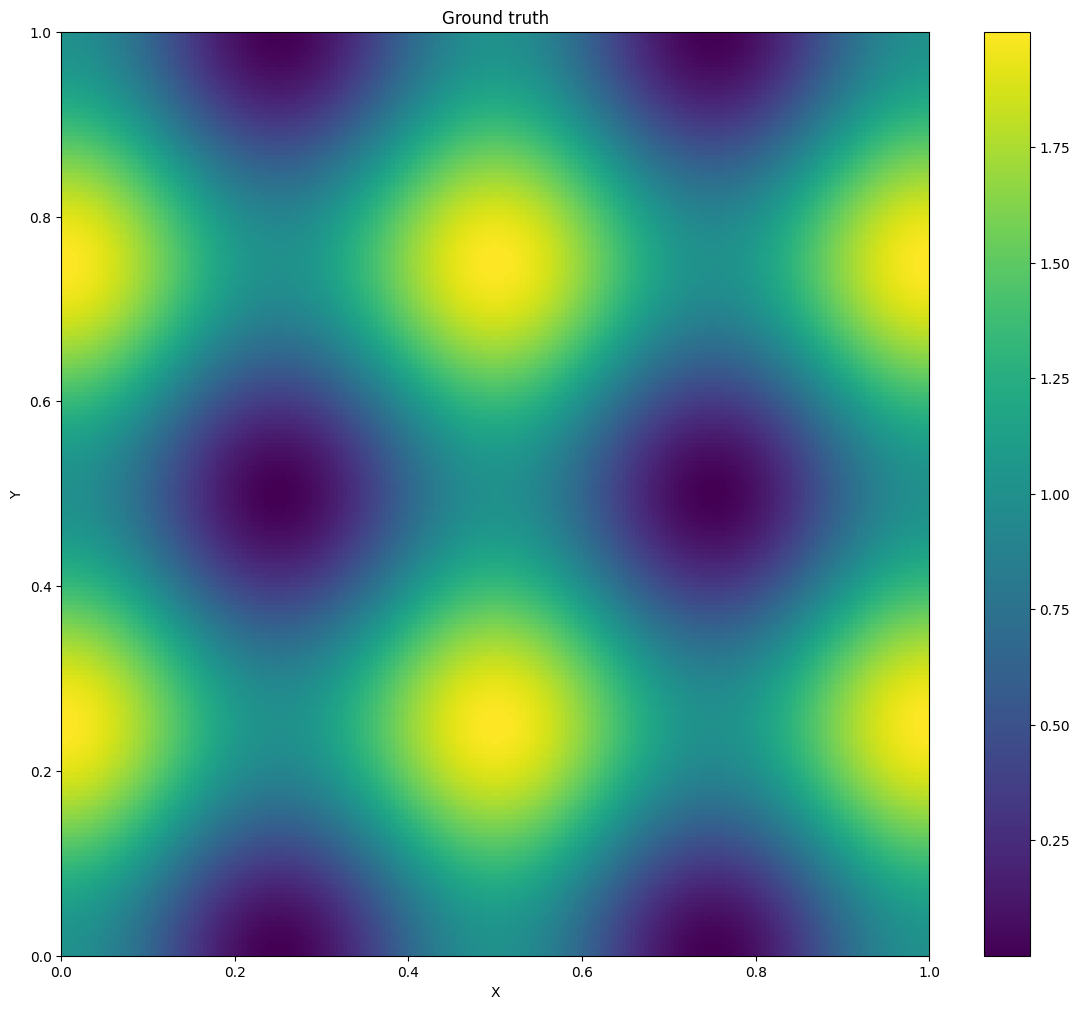

In [12]:
fig, ax = plt.subplots(figsize=(14, 12))
vmin = v2d[~v2d.isnan()].min()
vmax = v2d[~v2d.isnan()].max()

c = ax.pcolormesh(x2d, y2d, v2d,cmap='viridis',shading='auto', vmin=vmin, vmax=vmax)
ax.set_title('Ground truth')

# set the limits of the plot to the limits of the data
ax.axis([x2d.min(), x2d.max(), y2d.min(), y2d.max()])
plt.xlabel('X')
plt.ylabel('Y')
fig.colorbar(c, ax=ax)

fig_filename = os.path.join(parent_dir,'fig','synthetic_ground_truth.png')
plt.savefig(fig_filename, dpi = 300)

## Sensors

### Specs of high, medium and low quality sensors

Structural error: Normal distribution of mean = 0, and a standard deviation proportional to the value of ground truth

Remnant error: Normal distribution characterized by a mean and a std 

cf https://www.mdpi.com/1424-8220/21/6/2160/htm

In [13]:
# high quality sensors

In [14]:
mean_s_shq, std_s_shq = 0, 0.02

In [15]:
mean_r_shq, std_r_shq = 1e-2,1e-2

In [16]:
# medium quality sensors

In [17]:
mean_s_smq, std_s_smq = 0, 0.1

In [18]:
mean_r_smq, std_r_smq = 2e-2,2e-2

In [19]:
# low quality sensors

In [20]:
mean_s_slq, std_s_slq = 0, 0.3

In [21]:
mean_r_slq, std_r_slq = 5e-2,5e-2

### Generating data

In [22]:
nbPoint = 6400

In [23]:
np.random.seed(50)
X_e = np.random.uniform(L_x_e_min, L_x_e_max,nbPoint)
Y_e = np.random.uniform(L_y_e_min, L_y_e_max,nbPoint)

In [24]:
E = np.stack((X_e,Y_e),axis=1)

In [25]:
E = torch.tensor(E)

In [26]:
np.random.seed(50)
truth = torch.pow(torch.cos(E[:, 0] * 2 * math.pi),2) + torch.pow(torch.sin(E[:, 1] * (2 * math.pi)),2)

error_s_hq = torch.normal(mean_s_shq*torch.ones(truth.shape[0]), std_s_shq*truth)
error_r_hq = torch.normal(mean_r_shq*torch.ones(truth.shape[0]),std_r_shq*torch.ones(truth.shape[0]))
sensor_hq = truth + error_s_hq + error_r_hq

error_s_mq = torch.normal(mean_s_smq*torch.ones(truth.shape[0]), std_s_smq*truth)
error_r_mq = torch.normal(mean_r_smq*torch.ones(truth.shape[0]),std_r_smq*torch.ones(truth.shape[0]))
sensor_mq = truth + error_s_mq + error_r_mq

error_s_lq = torch.normal(mean_s_slq*torch.ones(truth.shape[0]), std_s_slq*truth)
error_r_lq = torch.normal(mean_r_slq*torch.ones(truth.shape[0]),std_r_slq*torch.ones(truth.shape[0]))
sensor_lq = truth + error_s_lq + error_r_lq

truth = torch.reshape(truth,(truth.shape[0],1))
sensor_hq = torch.reshape(sensor_hq,(sensor_hq.shape[0],1))
sensor_mq = torch.reshape(sensor_mq,(sensor_mq.shape[0],1))
sensor_lq = torch.reshape(sensor_lq,(sensor_lq.shape[0],1))

In [27]:
sensor_xytv = torch.cat((E,truth,sensor_hq,sensor_mq,sensor_lq),1)

### plot

In [28]:
error1 = sensor_xytv[:,2] - sensor_xytv[:,3]
error2 = sensor_xytv[:,2] - sensor_xytv[:,4]
error3 = sensor_xytv[:,2] - sensor_xytv[:,5]

error = torch.cat((error1,error2,error3),0)

In [29]:
vmin = error.min()
vmax = error.max()

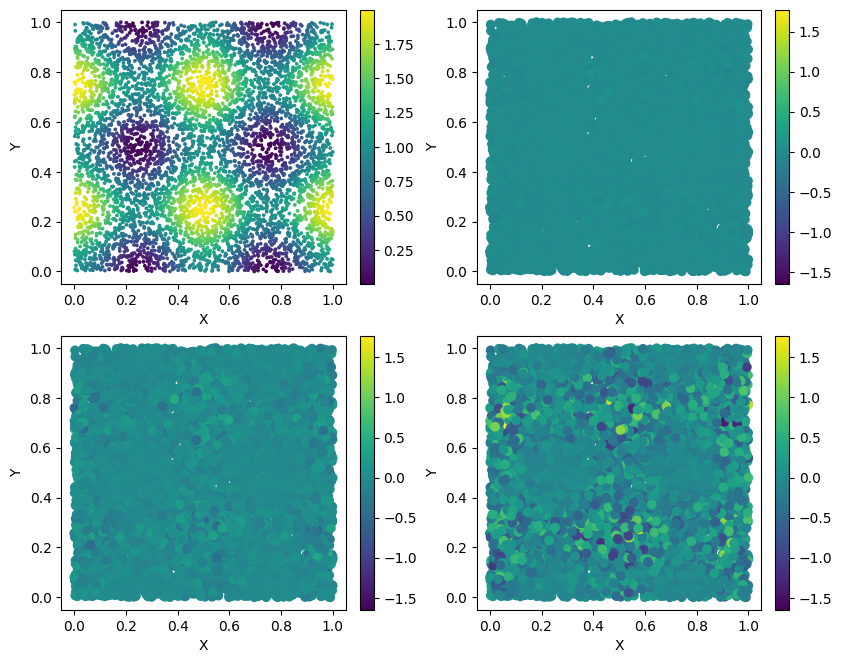

In [30]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=sensor_xytv[:,0], y=sensor_xytv[:,1], c=sensor_xytv[:,2],s=3)
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[0,1])
c1 = ax1.scatter(x=sensor_xytv[:,0], y=sensor_xytv[:,1], c=sensor_xytv[:,2] - sensor_xytv[:,3], vmin = vmin, vmax=vmax)
ax1.set(ylabel='Y',xlabel='X')

ax2 = fig.add_subplot(gs[1,0])
c2 = ax2.scatter(x=sensor_xytv[:,0], y=sensor_xytv[:,1], c=sensor_xytv[:,2] - sensor_xytv[:,4], vmin = vmin, vmax=vmax)
ax2.set(ylabel='Y',xlabel='X')

ax3 = fig.add_subplot(gs[1,1])
c3 = ax3.scatter(x=sensor_xytv[:,0], y=sensor_xytv[:,1], c=sensor_xytv[:,2] - sensor_xytv[:,5], vmin = vmin, vmax=vmax)
ax3.set(ylabel='Y',xlabel='X')


fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)
fig.colorbar(c3, ax=ax3)

fig_filename = os.path.join(parent_dir,'fig','synth_sensor.png')
plt.savefig(fig_filename, dpi = 300)


### save

In [31]:
newpath = os.path.join(parent_dir,'session','synthetic_sensor_'+str(nbPoint))
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [32]:
dataset = pd.DataFrame(sensor_xytv.numpy(), columns = ['x','y','truth','sensor_hq','sensor_mq','sensor_lq'])
tabpath = os.path.join(newpath,'tab')
if not os.path.exists(tabpath):
    os.makedirs(tabpath)
measure_filename = os.path.join(tabpath,'dataset.csv')
dataset.to_csv(measure_filename)

## Pixel sensors

### Specs of high, medium and low quality pixel sensors

Structural error: Normal distribution of mean = 0, and a standard deviation proportional to the value of ground truth

Remnant error: Normal distribution characterized by a mean and a std 

cf https://www.mdpi.com/1424-8220/21/6/2160/htm

### Specs of high quality and low quality pixel sensors

#### high quality sensors

In [33]:
mean_s_phq, std_s_phq = 0, 0.02

In [34]:
mean_r_phq, std_r_phq = 5e-2,1e-2

#### medium quality sensors

In [35]:
mean_s_pmq, std_s_pmq= 0, 0.1

In [36]:
mean_r_pmq, std_r_pmq = 5e-2,1e-2

#### low quality sensors

In [37]:
mean_s_plq, std_s_plq = 0, 0.3

In [38]:
mean_r_plq, std_r_plq = 5e-2,5e-2

### Generating data

In [39]:
bins = 30

In [40]:
agg_truth = torch.zeros([bins, bins])
value_hq = torch.zeros([bins, bins])
value_mq = torch.zeros([bins, bins])
value_lq = torch.zeros([bins, bins])
inc2d = torch.zeros([bins, bins])

In [41]:
x2d, y2d = np.meshgrid(np.linspace(L_x_e_min, L_x_e_max, bins), np.linspace(L_y_e_min, L_y_e_max, bins))

size = (L_x_e_max - L_x_e_min)/bins

x2d_low, y2d_low = np.meshgrid(np.linspace(L_x_e_min-size/2, L_x_e_max-2/bins, bins), np.linspace(L_y_e_min-size/2, L_y_e_max-size/2, bins))
x2d_up, y2d_up   = np.meshgrid(np.linspace(L_x_e_min+size/2, L_x_e_max+2/bins, bins), np.linspace(L_y_e_min+size/2, L_y_e_max+size/2, bins))

In [42]:
np.random.seed(50)
for i in range(bins):
    for j in range(bins):
        ind = (truth_xytv[:,0]>=x2d_low[i,j]) & (truth_xytv[:,0]<x2d_up[i,j]) & (truth_xytv[:,1]>=y2d_low[i,j]) & (truth_xytv[:,1]<y2d_up[i,j])
        agg_truth[i,j] = truth_xytv[ind,2].mean() 
        error_s_hq = torch.normal(mean_s_phq*torch.ones(1), std_s_phq*agg_truth[i,j])
        error_r_hq = torch.normal(mean_r_phq*torch.ones(1),std_r_phq*torch.ones(1))
        value_hq[i,j] = agg_truth[i,j] + error_s_hq + error_r_hq
        
        error_s_mq = torch.normal(mean_s_pmq*torch.ones(1), std_s_pmq*agg_truth[i,j])
        error_r_mq = torch.normal(mean_r_pmq*torch.ones(1),std_r_pmq*torch.ones(1))
        value_mq[i,j] = agg_truth[i,j] + error_s_mq + error_r_mq
        
        error_s_lq = torch.normal(mean_s_plq*torch.ones(1), std_s_plq*agg_truth[i,j])
        error_r_lq = torch.normal(mean_r_plq*torch.ones(1),std_r_plq*torch.ones(1))
        value_lq[i,j] = agg_truth[i,j] + error_s_lq + error_r_lq
        

### save

In [43]:
x_e = torch.reshape(torch.tensor(x2d),(x2d.shape[0]*x2d.shape[1],1))
y_e = torch.reshape(torch.tensor(y2d),(y2d.shape[0]*y2d.shape[1],1))

v_e_agg_truth = torch.reshape(agg_truth,(agg_truth.shape[0]*agg_truth.shape[1],1))
v_e_hq = torch.reshape(value_hq,(value_hq.shape[0]*value_hq.shape[1],1))
v_e_mq = torch.reshape(value_mq,(value_mq.shape[0]*value_mq.shape[1],1))
v_e_lq = torch.reshape(value_lq,(value_lq.shape[0]*value_lq.shape[1],1))

In [44]:
pixel_xytv = torch.cat((x_e,y_e,v_e_agg_truth,v_e_hq,v_e_mq,v_e_lq),1)

In [45]:
newpath = os.path.join(parent_dir,'session','synth_pixel_'+str(bins**2))
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [46]:
dataset = pd.DataFrame(pixel_xytv.numpy(), columns = ['x','y','pixel_truth','pixel_hq','pixel_mq','pixel_lq'])
tabpath = os.path.join(newpath,'tab')
if not os.path.exists(tabpath):
    os.makedirs(tabpath)
measure_filename = os.path.join(tabpath,'dataset.csv')
dataset.to_csv(measure_filename)

### plot

In [47]:
error1 = pixel_xytv[:,2] - pixel_xytv[:,3]
error2 = pixel_xytv[:,2] - pixel_xytv[:,4]
error3 = pixel_xytv[:,2] - pixel_xytv[:,5]
error = torch.cat((error1,error2,error3),0)

In [48]:
vmin = error.min()
vmax = error.max()

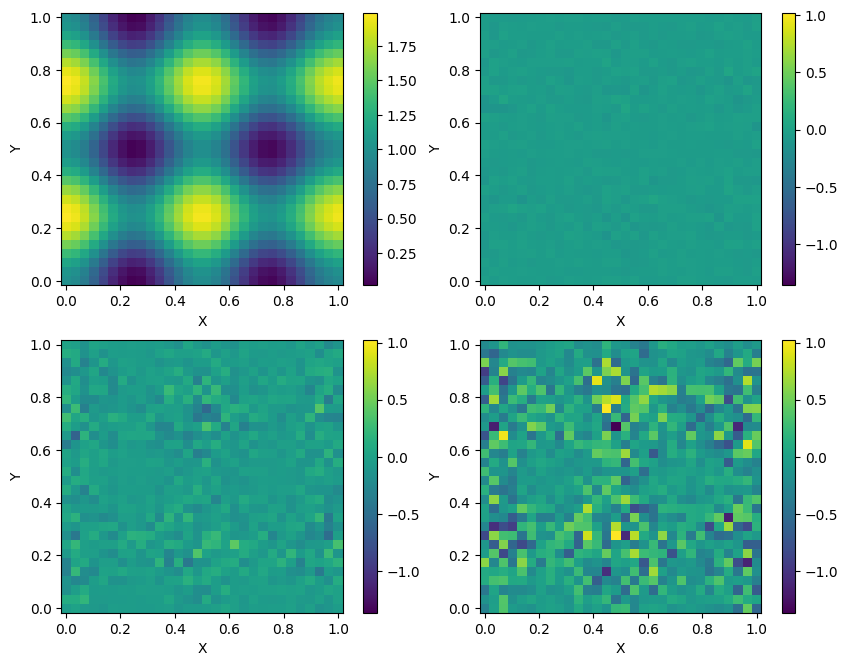

In [49]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.pcolormesh(x2d, y2d, agg_truth,cmap='viridis',shading='auto')
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[0,1])
c1 = ax1.pcolormesh(x2d, y2d, agg_truth-value_hq,cmap='viridis',shading='auto', vmin=vmin, vmax=vmax)
ax1.set(ylabel='Y',xlabel='X')

ax2 = fig.add_subplot(gs[1,0])
c2 = ax2.pcolormesh(x2d, y2d, agg_truth-value_mq,cmap='viridis',shading='auto', vmin=vmin, vmax=vmax)
ax2.set(ylabel='Y',xlabel='X')

ax3 = fig.add_subplot(gs[1,1])
c3 = ax3.pcolormesh(x2d, y2d, agg_truth-value_lq,cmap='viridis',shading='auto', vmin=vmin, vmax=vmax)
ax3.set(ylabel='Y',xlabel='X')


fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)
fig.colorbar(c3, ax=ax3)

fig_filename = os.path.join(parent_dir,'fig','synth_pix.png')
plt.savefig(fig_filename, dpi = 300)


## Gathering signals

In [50]:
nb_sampling = nbPoint
p_agg_truth_list = []
p_hq_list = []
p_mq_list = []
p_lq_list = []
for i in range(nbPoint):
    dist = torch.pow(torch.pow(sensor_xytv[i,0]-pixel_xytv[:,0],2) + torch.pow(sensor_xytv[i,1]-pixel_xytv[:,1],2),0.5)
    bool_ = dist == torch.min(dist)
    ind = [j for j, val in enumerate(bool_) if val]
    p_agg_truth_list.append(pixel_xytv[ind,2])
    p_hq_list.append(pixel_xytv[ind,3])
    p_mq_list.append(pixel_xytv[ind,4])
    p_lq_list.append(pixel_xytv[ind,5])

p_agg_truth = torch.cat(p_agg_truth_list, dim=0)
p_hq = torch.cat(p_hq_list, dim=0)
p_mq = torch.cat(p_mq_list, dim=0)
p_lq = torch.cat(p_lq_list, dim=0)  

tmp_p_agg_truth = torch.reshape(p_agg_truth,(p_agg_truth.shape[0],1))
tmp_p_hq = torch.reshape(p_hq,(p_hq.shape[0],1))
tmp_p_mq = torch.reshape(p_mq,(p_mq.shape[0],1))
tmp_p_lq = torch.reshape(p_lq,(p_lq.shape[0],1))

all_xyv = torch.cat((sensor_xytv,tmp_p_agg_truth,tmp_p_hq,tmp_p_mq,tmp_p_lq),1)
    
newpath = os.path.join(parent_dir,'session','synth_all_'+str(nb_sampling),'tab')
if not os.path.exists(newpath):
    os.makedirs(newpath)
f = os.path.join(newpath,'dataset.csv')
data = pd.DataFrame(all_xyv.numpy())
data.columns = ['x', 'y','truth','sensor_hq','sensor_mq','sensor_lq','agg_truth','pixel_hq','pixel_mq','pixel_lq']
data.to_csv(f,index=False)

### Accuracy and precision plot

In [51]:
def rmse(pred,target):
    return np.sqrt(np.mean((pred - target)**2))
def bias(pred,target):
    return np.mean(pred - target)
def variance(pred,target):
    b = bias(pred,target)
    return np.mean(np.abs(pred - target - b))**2

In [52]:
rmse_sensors_hq = rmse(data.loc[:,'sensor_hq'],data.loc[:,'truth'])

In [53]:
variance_sensors_hq = variance(data.loc[:,'sensor_hq'],data.loc[:,'truth'])

In [54]:
rmse_sensors_mq = rmse(data.loc[:,'sensor_mq'],data.loc[:,'truth'])

In [55]:
variance_sensors_mq = variance(data.loc[:,'sensor_mq'],data.loc[:,'truth'])

In [56]:
rmse_sensors_lq = rmse(data.loc[:,'sensor_lq'],data.loc[:,'truth'])

In [57]:
variance_sensors_lq = variance(data.loc[:,'sensor_lq'],data.loc[:,'truth'])

In [58]:
rmse_pixels_hq = rmse(data.loc[:,'pixel_hq'],data.loc[:,'truth'])

In [59]:
variance_pixels_hq = variance(data.loc[:,'pixel_hq'],data.loc[:,'truth'])

In [60]:
rmse_pixels_mq = rmse(data.loc[:,'pixel_mq'],data.loc[:,'truth'])

In [61]:
variance_pixels_mq = variance(data.loc[:,'pixel_mq'],data.loc[:,'truth'])

In [62]:
rmse_pixels_lq = rmse(data.loc[:,'pixel_lq'],data.loc[:,'truth'])

In [63]:
variance_pixels_lq = variance(data.loc[:,'pixel_lq'],data.loc[:,'truth'])

In [64]:
ap = pd.DataFrame(data={'RMSE': [rmse_sensors_hq ,rmse_sensors_mq,rmse_sensors_lq ,rmse_pixels_hq,rmse_pixels_mq ,rmse_pixels_lq],
                        'variance': [variance_sensors_hq,variance_sensors_mq,variance_sensors_lq,variance_pixels_hq,variance_pixels_mq,variance_pixels_lq]})

In [65]:
s = pd.Series(['sensor_hq','sensor_mq','sensor_lq','pixel_hq','pixel_mq','pixel_lq'])

In [66]:
ap = ap.set_index([s])

In [67]:
ap

,RMSE,variance
sensor_hq,0.026387,0.000339
sensor_mq,0.118162,0.007114
sensor_lq,0.345956,0.061272
pixel_hq,0.084882,0.003287
pixel_mq,0.138325,0.009812
pixel_lq,0.335373,0.060552


/tmp/ipykernel_8467/2742978050.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(ap["RMSE"][0]-0.01, ap["variance"][0]+0.002, 'HQS')
/tmp/ipykernel_8467/2742978050.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(ap["RMSE"][1]-0.01, ap["variance"][1]+0.002, 'MQS')
/tmp/ipykernel_8467/2742978050.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(ap["RMSE"][2]+0.001, ap["variance"][2]+0.002, 'LQS')
/tmp

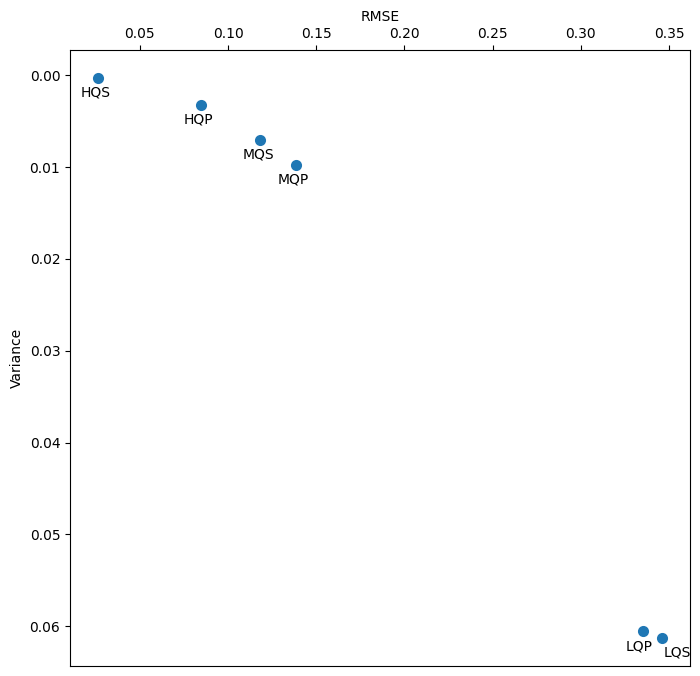

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xlabel('RMSE')    
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.scatter(ap.loc[:,"RMSE"],ap.loc[:,"variance"], linewidth=2.0)

ax.text(ap["RMSE"][0]-0.01, ap["variance"][0]+0.002, 'HQS')
ax.text(ap["RMSE"][1]-0.01, ap["variance"][1]+0.002, 'MQS')
ax.text(ap["RMSE"][2]+0.001, ap["variance"][2]+0.002, 'LQS')
ax.text(ap["RMSE"][3]-0.01, ap["variance"][3]+0.002, 'HQP')
ax.text(ap["RMSE"][4]-0.01, ap["variance"][4]+0.002, 'MQP')
ax.text(ap["RMSE"][5]-0.01, ap["variance"][5]+0.002, 'LQP')

ax.set(ylabel='Variance')

fig_filename = os.path.join(parent_dir,'fig','synth_qqplot.png')
plt.savefig(fig_filename, dpi = 300)